In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import math
import os 
import torch.nn.functional as F

import importlib
import data_analysis
importlib.reload(data_analysis)

import autoencoder
importlib.reload(autoencoder)

import utils
importlib.reload(utils)

%matplotlib inline
matplotlib.pyplot.rc('text', usetex=True)
fontsize = 18


print(f'Working in {os.getcwd()}')

Working in /projects/IceDynamics/Stage_M2/code


In [2]:
from utils import get_freer_gpu

device = get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 21270 MB free memory 


In [3]:
from data_analysis import Simulation
from data_analysis import compatible_path
current_directory = compatible_path('../')

simulation = Simulation(current_directory, normalize = True)
time, x, z, u, w, T, umean, wmean, Tmean = map(lambda x: torch.tensor(x).to(device), simulation.import_data())
simulation.image_rgb()

h, l = np.shape(x)
m = len(time)
print(m)
N = h*l*3

print(simulation.Umax, simulation.Wmax, simulation.Tmax)

6249
3053.072463137826 2543.305241913497 0.07238184027748469


# Simple Linear Autoencoder

## Running algo

In [ ]:
class LinearAutoencoder(nn.Module):
    def __init__(self, n_channels, N):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_channels*N, 128*16), 
            nn.ReLU(), 
            nn.Linear(128*16, 64*16), 
            nn.ReLU(), 
            nn.Linear(64*16, 12*16))
        
        self.decoder = nn.Sequential(
            nn.Linear(12*16, 64*16), 
            nn.ReLU(), 
            nn.Linear(64*16, 128*16), 
            nn.ReLU(), 
            nn.Linear(128*16, n_channels*N),
            nn.Tanh())
        
    def forward(self, x):
        # print(f'size of x {x.shape}')
        x = x.float()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
class SimpleLinearAutoencoder(nn.Module):
    def __init__(self, N, K = 20, device = device):
        super().__init__()
        self.encoder = nn.Linear(N, K).to(device)
        
        self.decoder = nn.Sequential(
            nn.Linear(K, N), 
            nn.Tanh()).to(device)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
batch_size = 4
K = 128

dataset = SimuDataset(simulation)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(t)
print(torch.min(data), torch.max(data), data.shape)

model = SimpleLinearAutoencoder(N, K, device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor([3256, 1279, 2039, 5956])
tensor(-0.6998, device='cuda:0', dtype=torch.float64) tensor(0.7316, device='cuda:0', dtype=torch.float64) torch.Size([4, 12393])


In [22]:
num_epoch = 9
output = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    output.append((epoch, int(t),  map, reconstructed))

Epoch: 1, Loss: 0.0045
Epoch: 2, Loss: 0.0049
Epoch: 3, Loss: 0.0079
Epoch: 4, Loss: 0.0035
Epoch: 5, Loss: 0.0173
Epoch: 6, Loss: 0.0051
Epoch: 7, Loss: 0.0048
Epoch: 8, Loss: 0.0098
Epoch: 9, Loss: 0.0072


#### saving

In [23]:
torch.save(model.state_dict(), f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt')

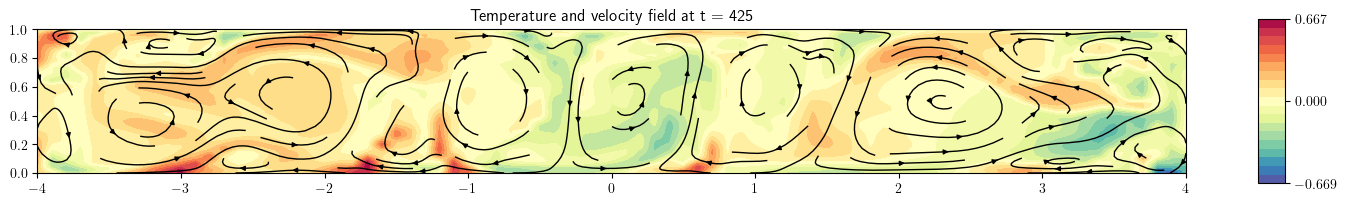

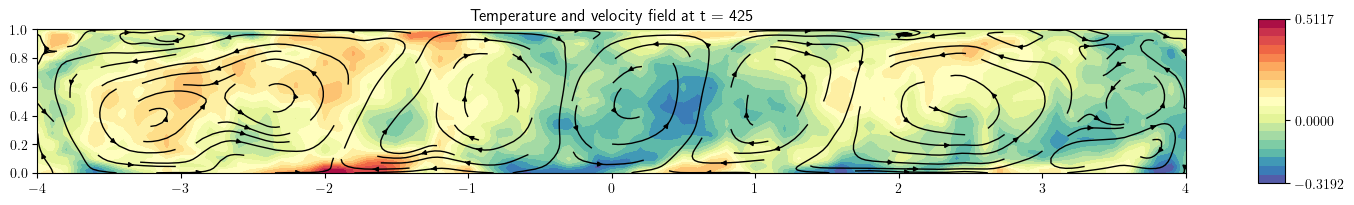

In [24]:
from utils import plot_field
epoch = 8

t = output[epoch][1]
field = np.reshape(np.array(output[epoch][2].cpu()), N)
reconstructed = output[epoch][3].cpu()
reconstructed = np.reshape(reconstructed.detach().numpy(), N)

plot_field(simulation, np.reshape(field[:h*l], (h, l)), np.reshape(field[h*l:2*h*l], (h,l)), np.reshape(field[2*h*l:], (h, l)), t)
plot_field(simulation, np.reshape(reconstructed[:h*l], (h, l)), np.reshape(reconstructed[h*l:2*h*l], (h,l)), np.reshape(reconstructed[2*h*l:], (h, l)), t)

## Analysis

In [13]:
K = 50
# encoder = torch.load(f'{current_directory}/results/autoencoder/simple_linear/encoder.pt')
# decoder = torch.load(f'{current_directory}/results/autoencoder/simple_linear/decoder.pt')
model = torch.load(f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt')

In [26]:
weights = model.encoder.cpu().weight.data
U = weights.numpy()

# weights_R = model.decoder.cpu().weight
# R = weights_R.numpy()
print(U.shape)

(128, 12393)


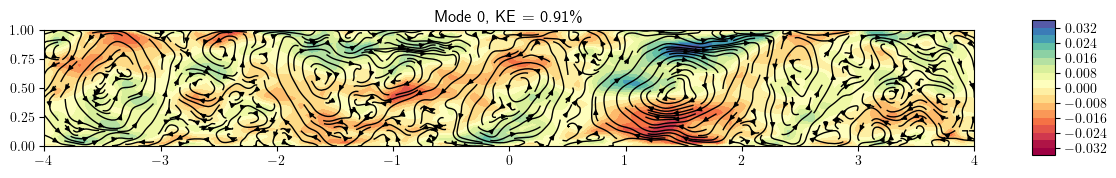

In [29]:
n_mode = 0

KE = np.sum(np.abs(U), axis = 1)/np.sum(np.abs(U))
sorting_indexes = np.argsort(KE)[::-1]

u_modes = np.reshape(np.swapaxes(U[:,:h*l], 0,1), (h, l, K))[:,:,sorting_indexes]
w_modes = np.reshape(np.swapaxes(U[:,h*l:2*h*l], 0, 1), (h, l, K))[:,:,sorting_indexes]
T_modes = np.reshape(np.swapaxes(U[:,2*h*l:], 0, 1), (h, l, K))[:,:,sorting_indexes]

from POD import streamplot_mode

streamplot_mode(u_modes, w_modes, u_modes, KE[sorting_indexes], n_mode, simulation.x, simulation.z)

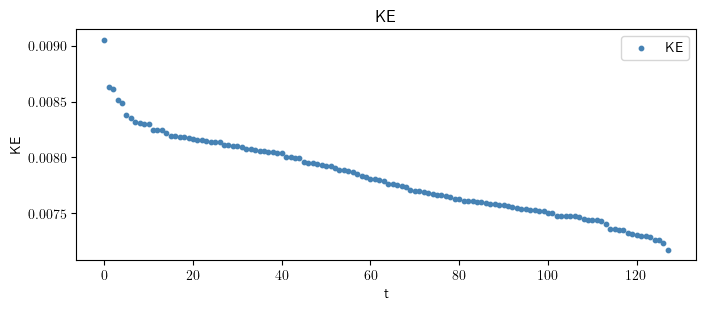

In [31]:
fig,ax = plt.subplots(figsize = (8, 3))

ax.scatter(range(len(KE)), KE[sorting_indexes], s = 10, c = 'steelblue', label = 'KE')
ax.set_title('KE')
ax.set_ylabel('KE')
ax.set_xlabel('t')
ax.legend()
# fig.tight_layout()
plt.show()

In [32]:
X = simulation.X.T
x = torch.from_numpy(X)
x = x.float()
print(x.shape)
print(x.T.shape)
print(x[0].shape)

torch.Size([6249, 12393])
torch.Size([12393, 6249])
torch.Size([12393])


In [38]:
K = 50
autoencoder = SimpleLinearAutoencoder(N, K, device)

autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt'))
autoencoder.eval()  # Set the model to evaluation mode


with torch.no_grad():
    encoded_data = autoencoder.encoder(x.to(device))

with torch.no_grad():
    decoded_data = autoencoder.decoder(encoded_data)

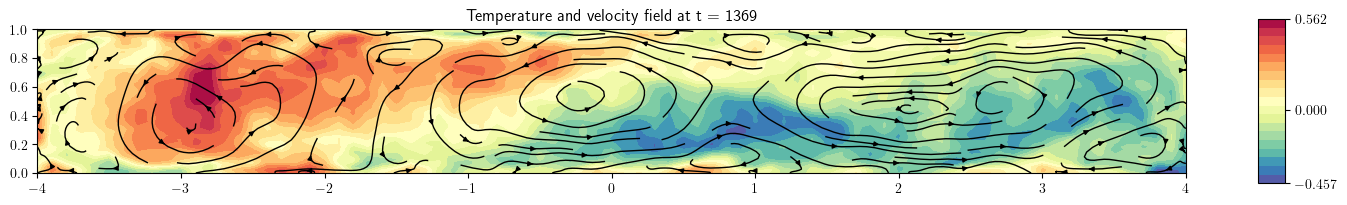

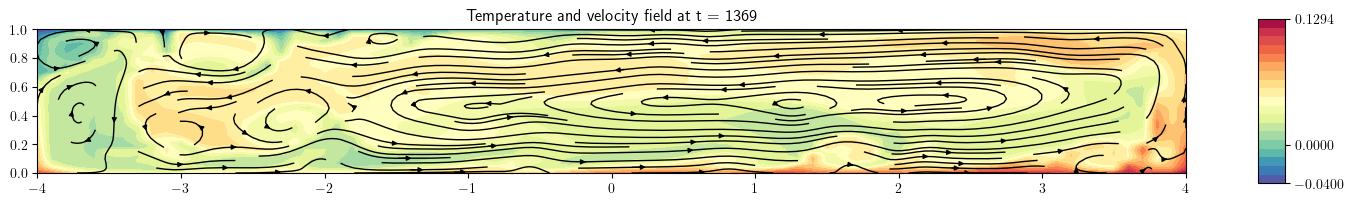

In [39]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy())

t = 1369
decoded_simulation.plot_field(t)
simulation.plot_field(t)

In [40]:
decoded_simulation.save_clip(1350, 1400, f'{current_directory}/results/autoencoder/simple_linear/snapshots/')

In [41]:
from utils import make_gif

make_gif(f'{current_directory}/results/autoencoder/simple_linear/snapshots/', f'{current_directory}/results/gif/linear_ae_decoded_field_K{K}.gif', 10)

GIF created at: ..//results/autoencoder/simple_linear/snapshots/linear_ae_decoded_field_K50.gif


# CNN

## Algo

#### V1

In [6]:
size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)

class ConvolutionalAutoencoder(nn.Module):

    def __init__(self, device, n_channels = 64, kernel_size = 3, stride = 1, padding = 1, bias = True):
        super().__init__()
        #shape : B * 3 * 81 * 51
        self.encoder = nn.Sequential(
            nn.Conv2d(3, n_channels//2, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.ReLU(), 
            nn.Upsample(size=size1, mode='bilinear', align_corners=False), 
            nn.Conv2d(n_channels//2, n_channels, kernel_size, stride = stride, padding = padding, bias = bias),
            nn.ReLU(),
            nn.Upsample(size=size2, mode='bilinear', align_corners=False), 
            nn.Conv2d(n_channels, n_channels, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.ReLU(),
            nn.Upsample(size=size3, mode='bilinear', align_corners=False)).to(device)
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_channels, n_channels//2, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.ReLU(), 
            nn.Upsample(size=size2, mode='bilinear', align_corners=False), 
            nn.ConvTranspose2d(n_channels//2, n_channels, kernel_size, stride = stride, padding = padding, bias = bias),
            nn.ReLU(),
            nn.Upsample(size=size1, mode='bilinear', align_corners=False), 
            nn.ConvTranspose2d(n_channels, 3, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.Upsample(size=(81, 51), mode='bilinear', align_corners=False)).to(device)
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


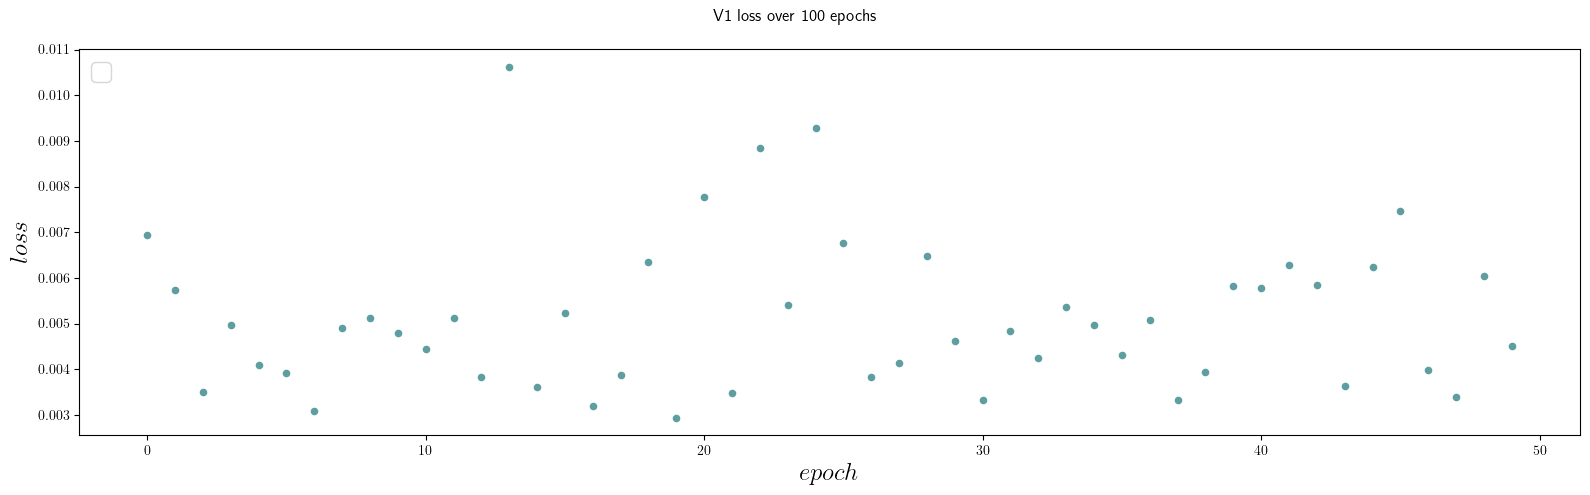

In [38]:
fig, ax1 = plt.subplots(figsize = (16, 5))


# ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(range(len(info)), [info[i][1] for i in range(len(info))], s = 20, c = 'cadetblue')

ax1.set_ylabel(r'$loss$', fontsize= fontsize)
ax1.set_xlabel(r'$epoch$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')
fig.suptitle("V1 loss over 100 epochs")
fig.tight_layout()

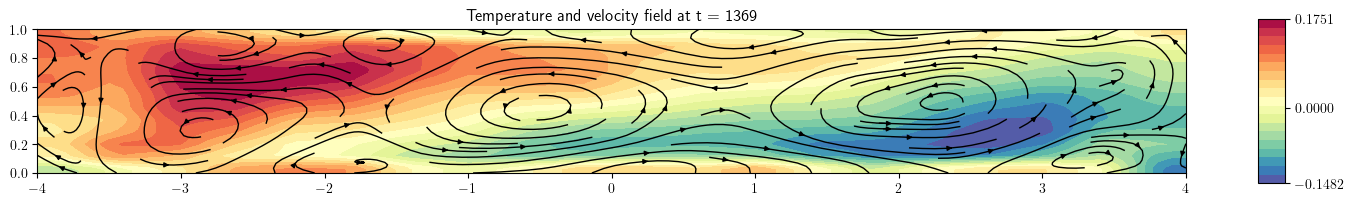

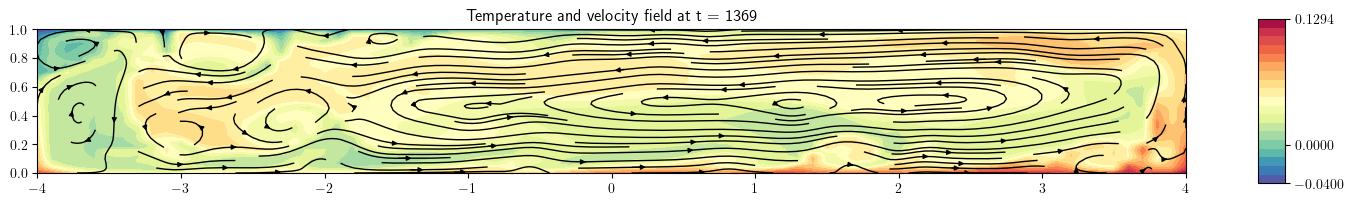

In [44]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy(), rgb = True)

t = 1369
decoded_simulation.plot_field(t)
simulation.plot_field(t)

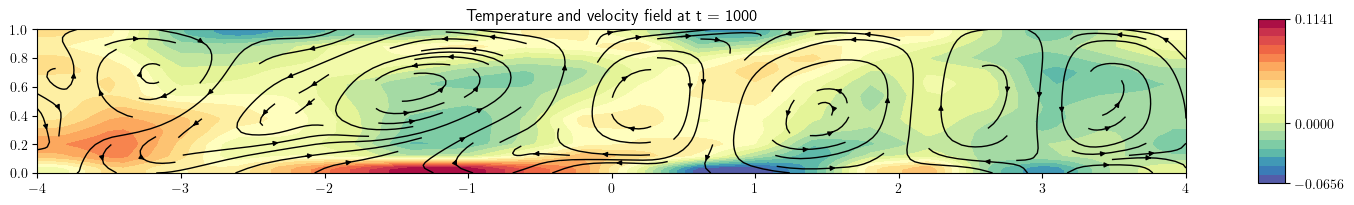

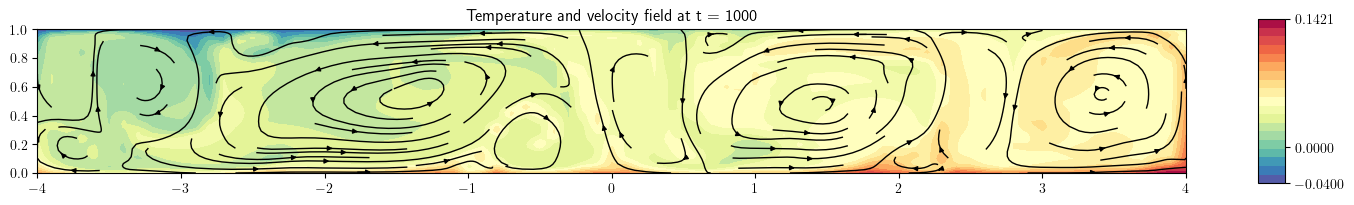

In [45]:
t = 1000
decoded_simulation.plot_field(t)
simulation.plot_field(t)

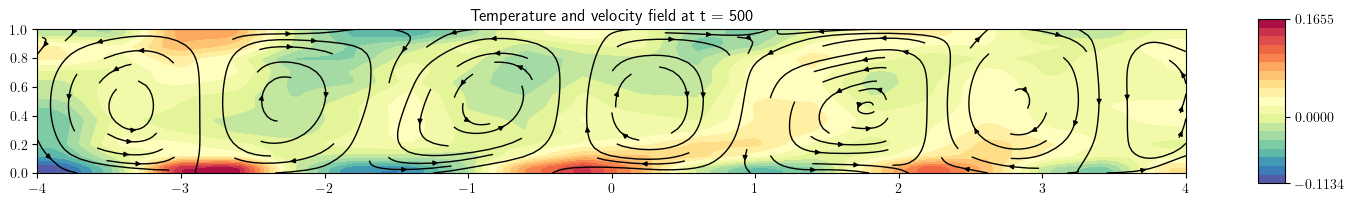

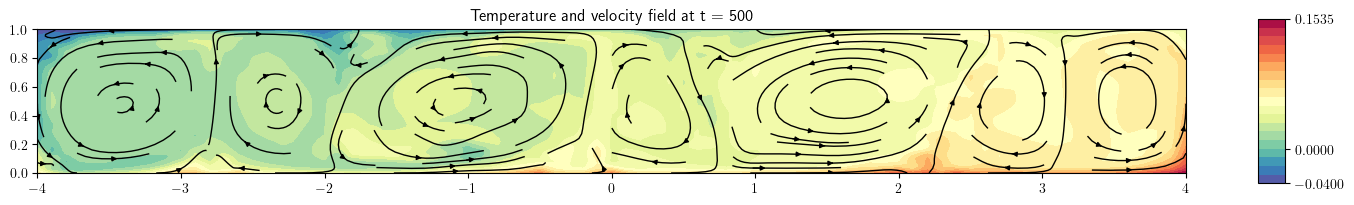

In [47]:
t = 500
decoded_simulation.plot_field(t)
simulation.plot_field(t)

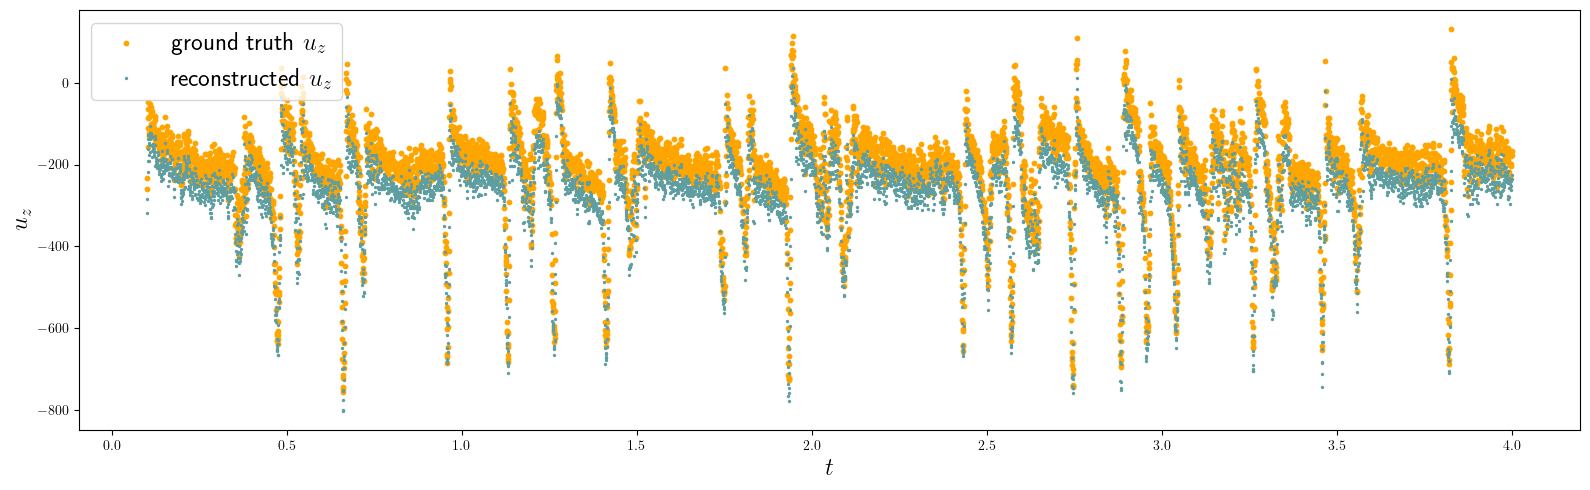

In [54]:
fig, ax1 = plt.subplots(figsize = (16, 5))


ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(time.cpu(), uz_decoded*simulation.Umax + uzmean, s = 2, c = 'cadetblue', label = r'reconstructed $u_z$')

ax1.set_ylabel(r'$u_z$', fontsize= fontsize)
ax1.set_xlabel(r'$t$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

#### V2

In [4]:
import torch.nn.functional as F
size1 = (40, 25)
size2 = (20, 12)
size3 = (10, 6)
size4 = (5, 3)

sizes = [size1, size2, size3, size4]

class ConvolutionalAutoencoder(nn.Module):

    def __init__(self, device, sizes, n_channels = 64, kernel_size = 3, stride = 1, padding = 1, bias = True):
        super().__init__()
        #shape : B * 3 * 81 * 51
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.device = device
        self.n_channels = n_channels
        self.sizes = sizes


        self.encoder = nn.Sequential(
            self.conv_block(3, self.n_channels), 
            nn.Upsample(size=sizes[0], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[1], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[2], mode='bilinear', align_corners=False), 
            
            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[3], mode='bilinear', align_corners=False),
            
            nn.Conv2d(n_channels, n_channels, kernel_size, stride = stride, padding = padding, bias = bias)).to(device)
        
        self.decoder = nn.Sequential(
            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[2], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[1], mode='bilinear', align_corners=False),

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[0], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=(81, 51), mode='bilinear', align_corners=False), 
            
            nn.ConvTranspose2d(n_channels, 3, kernel_size, stride = stride, padding = padding, bias = bias)).to(device)
    
    def conv_block(self, ch_in, ch_out):
         return nn.Sequential(nn.Conv2d(ch_in, ch_out, self.kernel_size, stride = self.stride, padding = self.padding, bias = self.bias),
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU(), 
                              nn.Conv2d(ch_out, ch_out, self.kernel_size, stride = self.stride, padding = self.padding, bias = self.bias), 
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU())
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
batch_size = 4
lr = 1e-3
weight_decay = 1e-5


dataset = SimuDataset(simulation, rgb = True, training_ratio = 0.9)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

tensor(-1.8921, device='cuda:0', dtype=torch.float64) tensor(0.7116, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [7]:
num_epoch = 100
output = []
info = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    info.append((epoch, loss.item()))
    output.append((epoch, map, reconstructed))

Epoch: 1, Loss: 0.0130
Epoch: 2, Loss: 0.0044
Epoch: 3, Loss: 0.0058
Epoch: 4, Loss: 0.0035
Epoch: 5, Loss: 0.0049
Epoch: 6, Loss: 0.0031
Epoch: 7, Loss: 0.0021
Epoch: 8, Loss: 0.0045
Epoch: 9, Loss: 0.0025
Epoch: 10, Loss: 0.0024
Epoch: 11, Loss: 0.0021
Epoch: 12, Loss: 0.0032
Epoch: 13, Loss: 0.0032
Epoch: 14, Loss: 0.0026
Epoch: 15, Loss: 0.0019
Epoch: 16, Loss: 0.0028
Epoch: 17, Loss: 0.0024
Epoch: 18, Loss: 0.0027
Epoch: 19, Loss: 0.0035
Epoch: 20, Loss: 0.0026
Epoch: 21, Loss: 0.0021
Epoch: 22, Loss: 0.0038
Epoch: 23, Loss: 0.0035
Epoch: 24, Loss: 0.0013
Epoch: 25, Loss: 0.0022
Epoch: 26, Loss: 0.0032
Epoch: 27, Loss: 0.0022
Epoch: 28, Loss: 0.0021
Epoch: 29, Loss: 0.0033
Epoch: 30, Loss: 0.0016
Epoch: 31, Loss: 0.0015
Epoch: 32, Loss: 0.0015
Epoch: 33, Loss: 0.0020
Epoch: 34, Loss: 0.0013
Epoch: 35, Loss: 0.0014
Epoch: 36, Loss: 0.0029
Epoch: 37, Loss: 0.0021
Epoch: 38, Loss: 0.0019
Epoch: 39, Loss: 0.0021
Epoch: 40, Loss: 0.0021
Epoch: 41, Loss: 0.0023
Epoch: 42, Loss: 0.0027
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


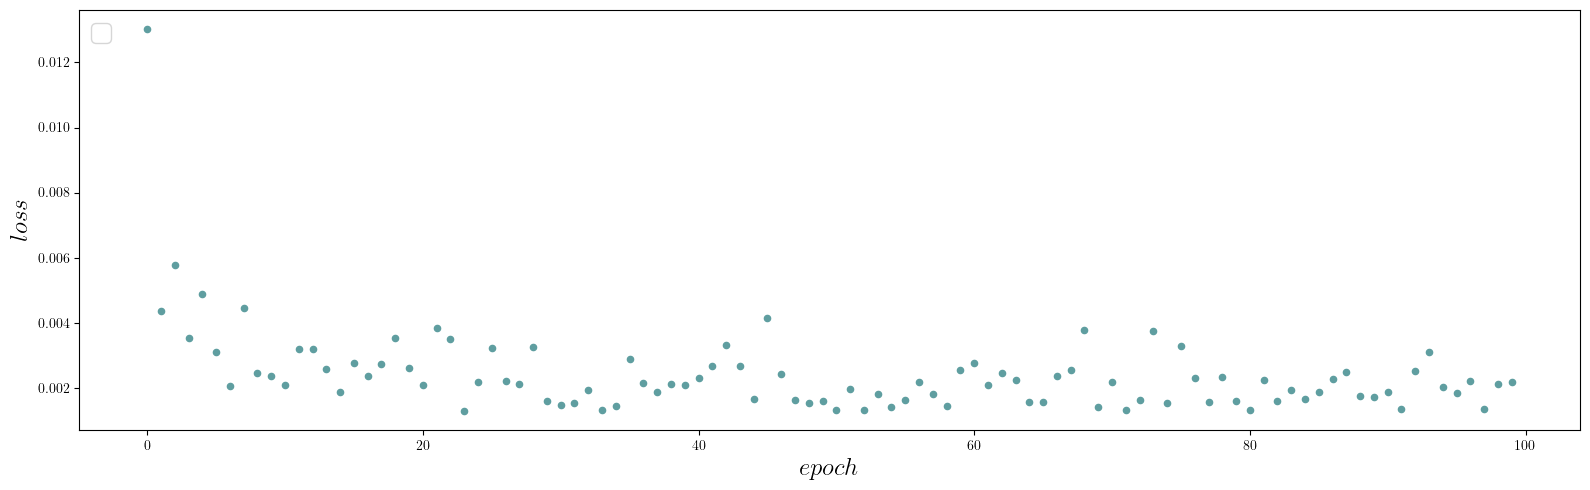

In [8]:
fig, ax1 = plt.subplots(figsize = (16, 5))


# ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(range(len(info)), [info[i][1] for i in range(len(info))], s = 20, c = 'cadetblue')

ax1.set_ylabel(r'$loss$', fontsize= fontsize)
ax1.set_xlabel(r'$epoch$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

In [15]:
from utils import info_text
directory = f'{current_directory}/results/autoencoder/cnn/'

torch.save(model.state_dict(), directory + f'model_bs{batch_size}_v2.pt')
info_text(directory, batch_size,lr, weight_decay, sizes, num_epoch, info, version = 2)

#### Test

In [23]:
batch_size = 4

dataset = SimuDataset(simulation, rgb = True)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size)

dataiter = iter(dataloader)
data = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor(-0.6562, device='cuda:0', dtype=torch.float64) tensor(0.5647, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [70]:
import torch.nn.functional as F

kernel_size = 3
stride = 1
padding = 1

size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)
n_channels = 64

conv1 = nn.Conv2d(3, n_channels//2, kernel_size, stride = 1, padding = 1).to(device) 
conv2 = nn.Conv2d(n_channels//2, n_channels, kernel_size, stride = 1, padding = 1).to(device) 
conv3 = nn.Conv2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv4 = nn.Conv2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv2 = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv3 = nn.ConvTranspose2d(n_channels, 3, kernel_size, stride = 1, padding = 1).to(device)

print(data.shape)

x = conv1(data.float()).to(device)

x = F.relu(x)
x = F.interpolate(x, size = size1)
print('Shape after conv1:', x.shape)
x = conv2(x)

x = F.relu(x)
x = F.interpolate(x, size = size2)
print('Shape after conv2:', x.shape)
x = conv3(x)
x = F.interpolate(x, size = size3)
print('Shape after conv3:', x.shape)
x = conv3(x)
print('Shape after conv4:', x.shape)
x = conv_inv(x)
x = F.interpolate(x, size = size2)
print('Shape after conv_inv1:', x.shape)
x = F.relu(x)
x = conv_inv2(x)
x = F.interpolate(x, size = size1)
print('Shape after conv_inv2:', x.shape)
x = F.relu(x)
x = conv_inv3(x)
x = F.interpolate(x, size = (81,51))
print('Shape after conv_inv3:', x.shape)

torch.Size([4, 3, 81, 51])
Shape after conv1: torch.Size([4, 32, 20, 12])
Shape after conv2: torch.Size([4, 64, 10, 6])
Shape after conv3: torch.Size([4, 64, 3, 2])
Shape after conv4: torch.Size([4, 64, 3, 2])
Shape after conv_inv1: torch.Size([4, 64, 10, 6])
Shape after conv_inv2: torch.Size([4, 64, 20, 12])
Shape after conv_inv3: torch.Size([4, 3, 81, 51])


## Analysis

In [5]:
batch_size = 4
directory = f'{current_directory}/results/autoencoder/cnn/'

with open(directory + f'model_bs{batch_size}_v2_info.txt', 'r') as file:
    content = file.read()
    print(content)

Information about Convolutionnal Autoencoder with batch size 4

batch size = 4
lr = 0.001
weight decay = 1e-05
size1 = (40, 25)
size2 = (20, 12)
size3 = (10, 6)
size4 = (5, 3)
num epoch = 100
epoch 0, loss 0.013023681938648224
epoch 1, loss 0.004357110243290663
epoch 2, loss 0.005769660696387291
epoch 3, loss 0.0035248808562755585
epoch 4, loss 0.004884442780166864
epoch 5, loss 0.0031116867903620005
epoch 6, loss 0.0020701473113149405
epoch 7, loss 0.0044545684941112995
epoch 8, loss 0.0024521041195839643
epoch 9, loss 0.002369949594140053
epoch 10, loss 0.002080387668684125
epoch 11, loss 0.0032022129744291306
epoch 12, loss 0.0031844470649957657
epoch 13, loss 0.0025802787858992815
epoch 14, loss 0.0018796016229316592
epoch 15, loss 0.0027674983721226454
epoch 16, loss 0.0023672091774642467
epoch 17, loss 0.0027330087032169104
epoch 18, loss 0.003538483288139105
epoch 19, loss 0.0026094643399119377
epoch 20, loss 0.002104395069181919
epoch 21, loss 0.003834487870335579
epoch 22, los

In [6]:
X = simulation.X_rgb
x = np.swapaxes(torch.from_numpy(X), 0, 1).cpu()
x = x.float()

print(x.shape)

torch.Size([6249, 3, 81, 51])


In [9]:
autoencoder = ConvolutionalAutoencoder(device)

autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/cnn/model_bs{batch_size}_v2.pt'))
autoencoder.eval()  # Set the model to evaluation mode


with torch.no_grad():
    encoded_data = autoencoder.encoder(x.to(device))

with torch.no_grad():
    decoded_data = autoencoder.decoder(encoded_data)

In [38]:
print(decoded_data.shape)
print(np.shape(simulation.X_rgb))

torch.Size([6249, 3, 81, 51])
(3, 6249, 81, 51)


In [11]:
print(simulation.Umax)

3053.072463137826


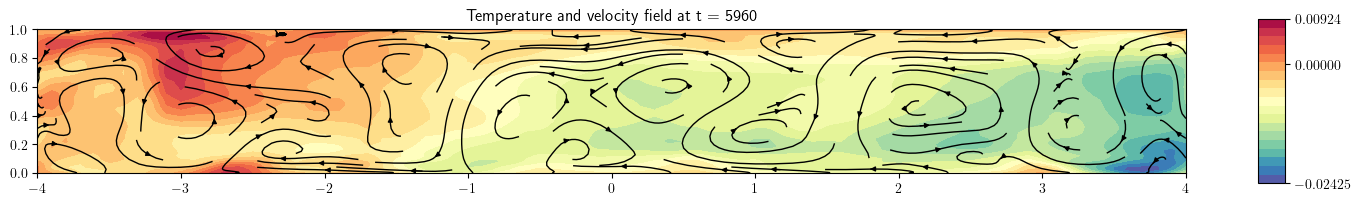

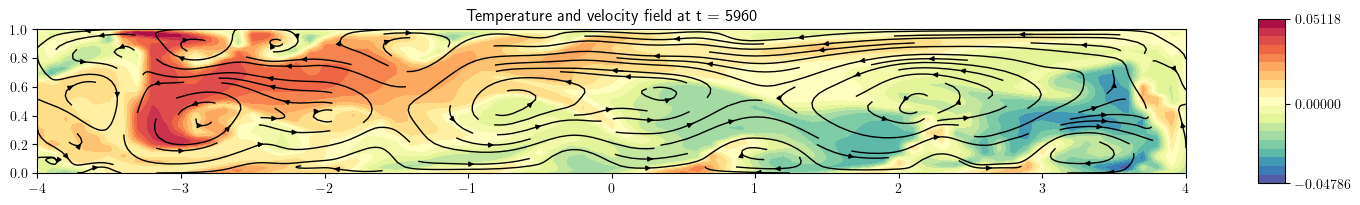

In [10]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy(), rgb = True, normalize = [simulation.Umax, simulation.Wmax, simulation.Tmax])

t = 5960
decoded_simulation.plot_field(t)
simulation.plot_field(t)

In [20]:
decoded_simulation.save_clip(1300, 1400, f'{current_directory}/results/autoencoder/cnn/snapshots/')

from utils import make_gif

make_gif(f'{current_directory}/results/autoencoder/cnn/snapshots/', f'{current_directory}/results/gif/cnn_decoded_field_bs{batch_size}_v2.gif', 10)

GIF created at: ..//results/gif/cnn_decoded_field_bs4_v2.gif


In [23]:
uz_decoded, uzmean_decoded = decoded_simulation.UZ()
uz, uzmean = simulation.UZ()

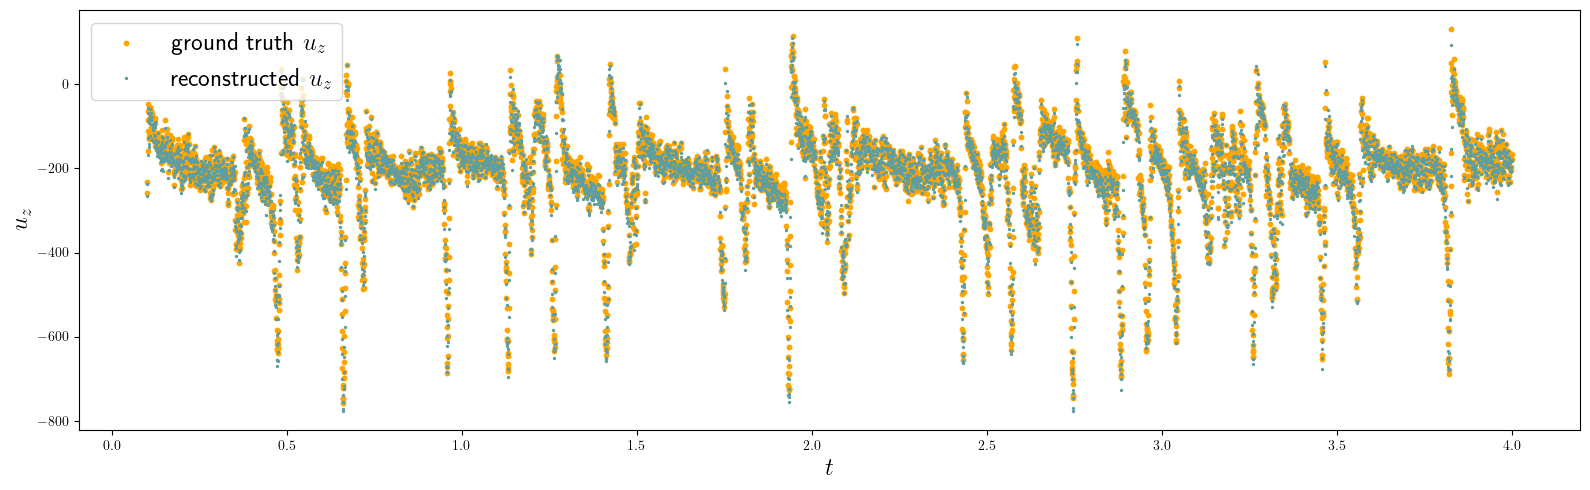

In [24]:
fig, ax1 = plt.subplots(figsize = (16, 5))


ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(time.cpu(), uz_decoded*simulation.Umax + uzmean, s = 2, c = 'cadetblue', label = r'reconstructed $u_z$')

ax1.set_ylabel(r'$u_z$', fontsize= fontsize)
ax1.set_xlabel(r'$t$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

# V3 With PCA

In [4]:
class ConvolutionalAutoencoder(nn.Module):

    def __init__(self, device, sizes, K = 128, n_channels = 64, kernel_size = 3, stride = 1, padding = 1, bias = True):
        super().__init__()
        #shape : B * 3 * 81 * 51
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.device = device
        self.n_channels = n_channels
        self.sizes = sizes
        self.N = n_channels * sizes[-1][0] * sizes[-1][1]
        print(self.N)
        self.K = K


        self.encoder = nn.Sequential(
            self.conv_block(3, self.n_channels), 
            nn.Upsample(size=sizes[0], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[1], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[2], mode='bilinear', align_corners=False), 
            
            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[3], mode='bilinear', align_corners=False),
            
            nn.Conv2d(n_channels, n_channels, kernel_size, stride = stride, padding = padding, bias = bias)).to(device)
        
        self.decoder = nn.Sequential(
            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[2], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[1], mode='bilinear', align_corners=False),

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=sizes[0], mode='bilinear', align_corners=False), 

            self.conv_block(self.n_channels, self.n_channels), 
            nn.Upsample(size=(81, 51), mode='bilinear', align_corners=False), 
            
            nn.ConvTranspose2d(n_channels, 3, kernel_size, stride = stride, padding = padding, bias = bias)).to(device)
        
        self.linear_encoder = nn.Linear(self.N, self.K).to(device)

        self.linear_decoder = nn.Sequential(nn.Linear(K, self.N), nn.Tanh()).to(device)
    
    def conv_block(self, ch_in, ch_out):
         return nn.Sequential(nn.Conv2d(ch_in, ch_out, self.kernel_size, stride = self.stride, padding = self.padding, bias = self.bias),
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU(), 
                              nn.Conv2d(ch_out, ch_out, self.kernel_size, stride = self.stride, padding = self.padding, bias = self.bias), 
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        encoded = torch.reshape(encoded, (encoded.shape[0],-1))
        # print(encoded.shape)
        encoded = self.linear_encoder(encoded)
        # print(encoded.shape)

        
        decoded = self.linear_decoder(encoded)
        # print(decoded.shape)
        decoded = torch.reshape(decoded, (decoded.shape[0], self.n_channels, self.sizes[-1][0], self.sizes[-1][1]))
        # print(decoded.shape)
        decoded = self.decoder(decoded)
        return decoded

In [6]:
from autoencoder import SimuDataset

batch_size = 4

dataset = SimuDataset(simulation, device,  rgb = True, training_ratio = 0.9)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

tensor(-0.7726, device='cuda:0', dtype=torch.float64) tensor(0.7753, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [8]:
lr = 1e-4
weight_decay = 0

size1 = (40, 25)
size2 = (20, 12)
size3 = (10, 6)
size4 = (5, 3)

K = 960

sizes = [size1, size2, size3, size4]

model = ConvolutionalAutoencoder(device = device, n_channels = 64,  sizes = sizes)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

960


In [27]:
num_epoch = 100
output = []
info = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    info.append((epoch, loss.item()))
    output.append((epoch, map, reconstructed))

Epoch: 1, Loss: 0.0110
Epoch: 2, Loss: 0.0077
Epoch: 3, Loss: 0.0094
Epoch: 4, Loss: 0.0099
Epoch: 5, Loss: 0.0058
Epoch: 6, Loss: 0.0061
Epoch: 7, Loss: 0.0053
Epoch: 8, Loss: 0.0040
Epoch: 9, Loss: 0.0045
Epoch: 10, Loss: 0.0061
Epoch: 11, Loss: 0.0049
Epoch: 12, Loss: 0.0035
Epoch: 13, Loss: 0.0036
Epoch: 14, Loss: 0.0045
Epoch: 15, Loss: 0.0046
Epoch: 16, Loss: 0.0028
Epoch: 17, Loss: 0.0040
Epoch: 18, Loss: 0.0042
Epoch: 19, Loss: 0.0030
Epoch: 20, Loss: 0.0040
Epoch: 21, Loss: 0.0028
Epoch: 22, Loss: 0.0032
Epoch: 23, Loss: 0.0031
Epoch: 24, Loss: 0.0037
Epoch: 25, Loss: 0.0026
Epoch: 26, Loss: 0.0029
Epoch: 27, Loss: 0.0035
Epoch: 28, Loss: 0.0037
Epoch: 29, Loss: 0.0031
Epoch: 30, Loss: 0.0031
Epoch: 31, Loss: 0.0033
Epoch: 32, Loss: 0.0031
Epoch: 33, Loss: 0.0036
Epoch: 34, Loss: 0.0033
Epoch: 35, Loss: 0.0021
Epoch: 36, Loss: 0.0037
Epoch: 37, Loss: 0.0043
Epoch: 38, Loss: 0.0039
Epoch: 39, Loss: 0.0027
Epoch: 40, Loss: 0.0033
Epoch: 41, Loss: 0.0027
Epoch: 42, Loss: 0.0030
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


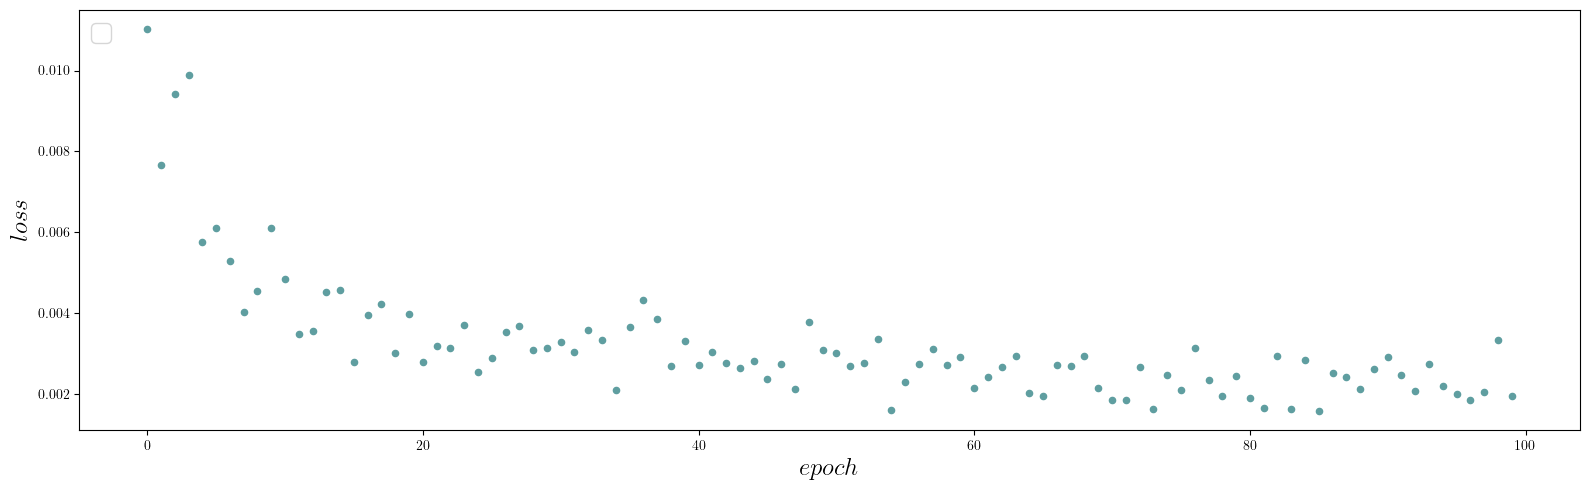

In [28]:
fig, ax1 = plt.subplots(figsize = (16, 5))


# ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(range(len(info)), [info[i][1] for i in range(len(info))], s = 20, c = 'cadetblue')

ax1.set_ylabel(r'$loss$', fontsize= fontsize)
ax1.set_xlabel(r'$epoch$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

In [29]:
from utils import info_text
directory = f'{current_directory}/results/autoencoder/cnn/'
torch.save(model.state_dict(), directory + f'model_bs{batch_size}_K{K}.pt')
info_text(directory, batch_size, sizes, info, version = 3, K = K, num_epoch = num_epoch, lr = lr, weight_decay = weight_decay)

In [19]:
batch_size = 4
K = 960
directory = f'{current_directory}/results/autoencoder/cnn/'

title = f'model_bs{batch_size}_K{K}_info.txt'
def get_variables_from_info_text(directory, title):
    variables = {}
    sizes = []
    with open(directory + title, 'r') as file:
        for line in file:
            if line.startswith('size'):
                size = eval(line.split('=')[1].strip())
                sizes.append(size)
            if '=' in line:
                key, value = line.split('=')
                key = key.strip()
                value = eval(value.strip())
                variables[key] = value
            elif line.startswith('epoch'):
                epoch, loss = line.split(',')
                epoch = int(epoch.split()[1])
                loss = float(loss.split()[1])
                variables[f'epoch_{epoch}'] = loss

    for key, value in variables.items():
        print(f"{key}: {value}")
    return variables, sizes

variables, sizes = get_variables_from_info_text(directory, title)

size1: (40, 25)
size2: (20, 12)
size3: (10, 6)
size4: (5, 3)
num_epoch: 100
lr: 0.0001
weight_decay: 0
epoch_1: 0.01102367788553238
epoch_2: 0.007676897570490837
epoch_3: 0.009425538592040539
epoch_4: 0.00987856276333332
epoch_5: 0.005751246586441994
epoch_6: 0.006108707282692194
epoch_7: 0.005289475433528423
epoch_8: 0.004029172006994486
epoch_9: 0.0045479219406843185
epoch_10: 0.006110329180955887
epoch_11: 0.004852179903537035
epoch_12: 0.0034937674645334482
epoch_13: 0.003566419007256627
epoch_14: 0.004534991458058357
epoch_15: 0.004586093593388796
epoch_16: 0.002791767939925194
epoch_17: 0.003966542426496744
epoch_18: 0.004223332274705172
epoch_19: 0.0030145514756441116
epoch_20: 0.003992190584540367
epoch_21: 0.0028014795389026403
epoch_22: 0.0031937784515321255
epoch_23: 0.0031456993892788887
epoch_24: 0.0037060680333524942
epoch_25: 0.0025540378410369158
epoch_26: 0.002892669290304184
epoch_27: 0.00353862252086401
epoch_28: 0.003685479052364826
epoch_29: 0.003088750410825014
ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


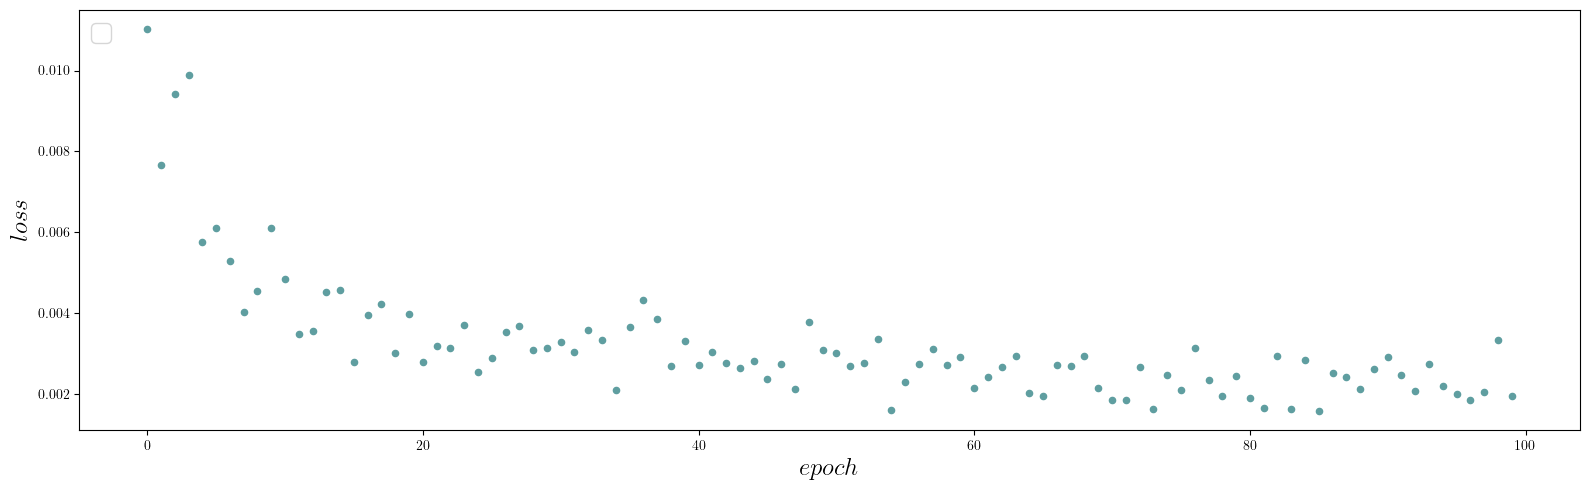

In [17]:
def losses_from_info(variables):
    epochs = []
    losses = []

    for key, value in variables.items():
        if key.startswith('epoch_'):
            epoch_number = int(key.split('_')[1])
            epochs.append(epoch_number)
            losses.append(value)
    return epochs, losses

epochs, losses = losses_from_info(variables)
fig, ax1 = plt.subplots(figsize = (16, 5))


# ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(range(len(epochs)), losses, s = 20, c = 'cadetblue')

ax1.set_ylabel(r'$loss$', fontsize= fontsize)
ax1.set_xlabel(r'$epoch$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

In [20]:
print(sizes)

[(40, 25), (20, 12), (10, 6), (5, 3)]


In [22]:
X = simulation.X_rgb
x = np.swapaxes(torch.from_numpy(X), 0, 1).cpu()
x = x.float()

print(x.shape)

autoencoder = ConvolutionalAutoencoder(device, sizes)

autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/cnn/model_bs{batch_size}_K{K}.pt'))
autoencoder.eval()  # Set the model to evaluation mode


with torch.no_grad():
    encoded_data = autoencoder.linear_encoder(autoencoder.encoder(x.to(device)))

with torch.no_grad():
    decoded_data = autoencoder.decoder(autoencoder.linear_decoder(encoded_data))

torch.Size([6249, 3, 81, 51])
960


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1518507x51 and 960x128)

In [24]:
autoencoder.encoder(x.to(device))

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.16 GiB. GPU 0 has a total capacity of 23.65 GiB of which 5.98 GiB is free. Process 2349801 has 2.88 GiB memory in use. Including non-PyTorch memory, this process has 14.76 GiB memory in use. Of the allocated memory 7.34 GiB is allocated by PyTorch, and 5.85 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [11]:
K

960

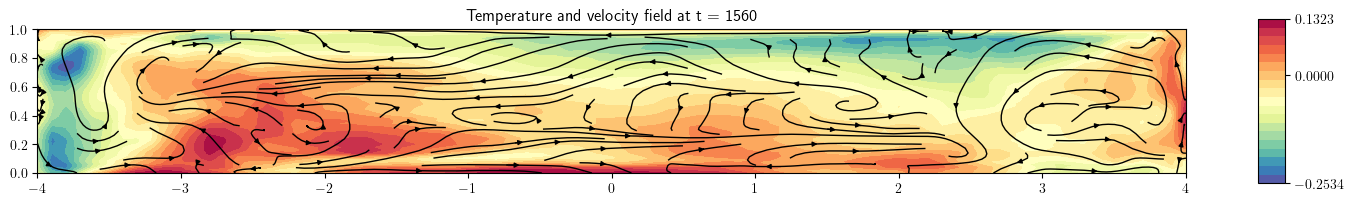

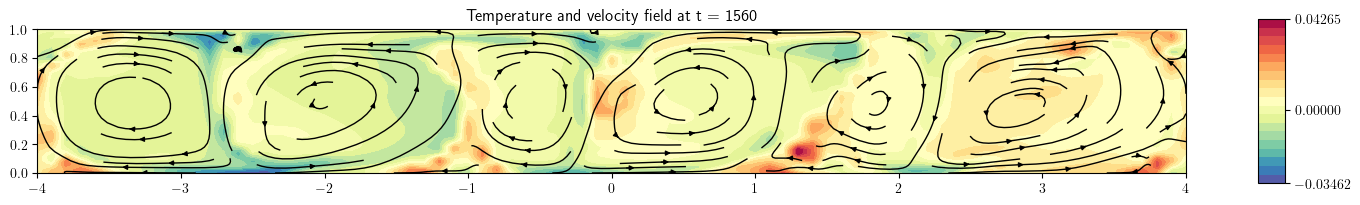

In [12]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy(), rgb = True)

t = 1560
decoded_simulation.plot_field(t)
simulation.plot_field(t)